=== CALIFORNIA DMV TOPOLOGICAL ANALYSIS ===
Attempting to download California state boundary...
✅ California state boundary added!


NameError: name 'cpx' is not defined

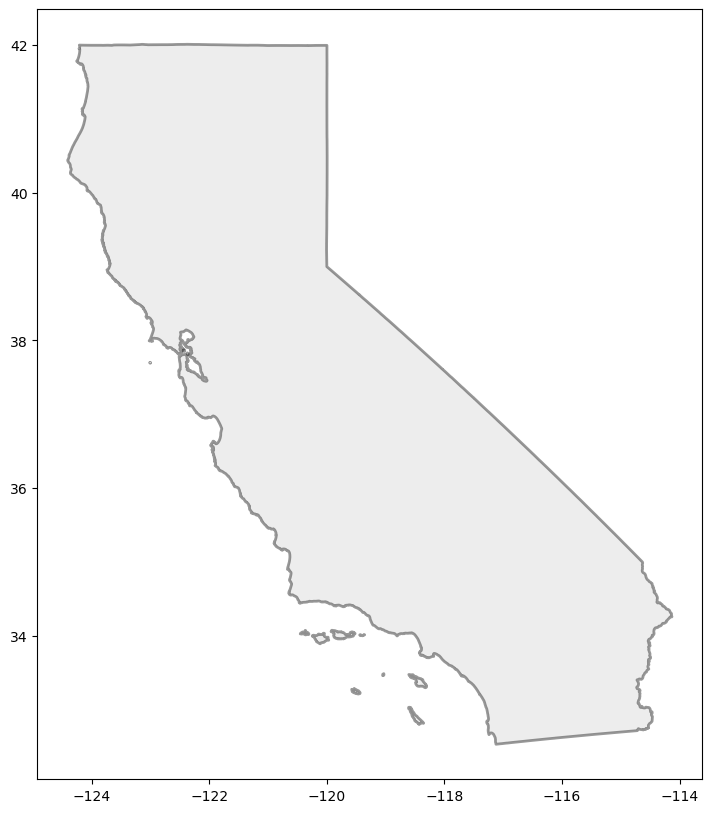

In [17]:
import numpy as np
import gudhi as gd
import geopandas as gpd
from shapely.geometry import LineString, Polygon, Point
import scipy.stats
import matplotlib.pyplot as plt

def plot_california_dmv_deathsimplices(cpx, all_pairs, hom_dim, ax, criteria='death', zscore_thresh=None, legend=False):
    '''
    Plot death simplices for California DMV offices (adapted from your plot_deathsimplices function)
    
    cpx: The filtered complex (your existing cpx)
    all_pairs: All (birth simplex, death simplex) pairs (your existing all_pairs) 
    hom_dim: {0, 1}. Homology dimension
    ax: matplotlib axis to plot on
    criteria: {'lifetime', 'death'}
    zscore_thresh: optional z-score threshold (if None, shows all)
    '''
    
    # Create DMV office points from your existing data
    try:
        # Try to use actual coordinates if available
        if 'latitude' in dmv_df.columns and 'longitude' in dmv_df.columns:
            lats = dmv_df['latitude'].values[:len(offices)]
            lons = dmv_df['longitude'].values[:len(offices)]
            print("Using actual geographic coordinates")
        else:
            # Use MDS to create 2D layout from distance matrix
            print("Creating layout from distance matrix...")
            from sklearn.manifold import MDS
            mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
            coords_2d = mds.fit_transform(D_matrix)
            lons = coords_2d[:, 0]
            lats = coords_2d[:, 1]
            
    except Exception as e:
        print(f"Error with coordinates: {e}")
        # Simple grid fallback
        n = len(offices)
        grid_size = int(np.ceil(np.sqrt(n)))
        lons = [(i % grid_size) for i in range(n)]
        lats = [(i // grid_size) for i in range(n)]
    
    # Create GeoDataFrame for DMV offices (equivalent to polls_df in your code)
    dmv_points = [Point(lon, lat) for lon, lat in zip(lons, lats)]
    polls_df = gpd.GeoDataFrame({
        'office_name': offices[:len(dmv_points)],
        'geometry': dmv_points
    })
    
    # Get simplex pairs for homology classes in dimension hom_dim
    # Only get finite homology classes (ones that have a death simplex)
    pairs = [pair for pair in all_pairs if len(pair[1]) == hom_dim + 2]
    
    if not pairs:
        print(f"No finite {hom_dim}D homology classes found!")
        return
    
    print(f"Found {len(pairs)} finite {hom_dim}D homology classes")
    
    # Calculate criteria, sort death simplices by criteria, calculate z-scores
    if criteria == "death":
        deathspx_criteria = [[pair[1], cpx.filtration(pair[1])] for pair in pairs]
    elif criteria == "lifetime":
        deathspx_criteria = [[pair[1], cpx.filtration(pair[1]) - cpx.filtration(pair[0])] for pair in pairs]
    
    deathspx_criteria.sort(key=lambda row: row[1], reverse=True)
    death_simplices = [item[0] for item in deathspx_criteria]
    criteria_vals = [item[1] for item in deathspx_criteria]
    
    # Calculate z-scores if we have multiple values
    if len(criteria_vals) > 1:
        zscores = scipy.stats.zscore(criteria_vals)
    else:
        zscores = [0] * len(criteria_vals)
    
    # Make geopandas dataframe where the polygons represent the death simplices
    death_geometries = []
    
    for deathspx in death_simplices:
        try:
            if hom_dim == 0:
                # 0D: Create buffered line between two points
                if len(deathspx) >= 2:
                    line_points = [polls_df.geometry.iloc[deathspx[j]] for j in range(2)]
                    line = LineString(line_points)
                    death_geometries.append(line.buffer(0.01))  # Adjust buffer size as needed
                else:
                    death_geometries.append(None)
                    
            elif hom_dim == 1:
                # 1D: Create triangle (polygon) from three points
                if len(deathspx) >= 3:
                    triangle_points = [polls_df.geometry.iloc[deathspx[j]] for j in range(3)]
                    triangle_coords = [(p.x, p.y) for p in triangle_points]
                    death_geometries.append(Polygon(triangle_coords))
                else:
                    death_geometries.append(None)
                    
        except Exception as e:
            print(f"Error creating geometry for simplex {deathspx}: {e}")
            death_geometries.append(None)
    
    # Filter out None geometries
    valid_indices = [i for i, geom in enumerate(death_geometries) if geom is not None]
    valid_geometries = [death_geometries[i] for i in valid_indices]
    valid_criteria = [criteria_vals[i] for i in valid_indices]
    valid_zscores = [zscores[i] for i in valid_indices]
    
    if not valid_geometries:
        print("No valid geometries created!")
        return
    
    # Create GeoDataFrame
    df_deathsimplices = gpd.GeoDataFrame({
        'geometry': valid_geometries,
        'criteria': valid_criteria,
        'zscore': valid_zscores
    })
    
    # Apply z-score filtering if requested
    if zscore_thresh is not None:
        df_deathsimplices_truncated = df_deathsimplices[df_deathsimplices['zscore'] > zscore_thresh]
        print(f"After z-score filtering (>{zscore_thresh}): {len(df_deathsimplices_truncated)} features")
    else:
        df_deathsimplices_truncated = df_deathsimplices
        print(f"Showing all {len(df_deathsimplices_truncated)} features")
    
    # Plot California state boundaries
    try:
        # Try to get California state shape using built-in data or online source
        try:
            # Option 1: Use geopandas built-in data (if available)
            import requests
            import io
            
            # Download California boundary from a reliable source
            print("Downloading California state boundary...")
            url = "https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-states.geojson"
            response = requests.get(url)
            
            if response.status_code == 200:
                us_states = gpd.read_file(io.StringIO(response.text))
                ca_state = us_states[us_states['NAME'] == 'California']
                
                if not ca_state.empty:
                    ca_state.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=2, alpha=0.3, zorder=1)
                    print("California state boundary added successfully!")
                else:
                    print("California not found in state data")
            else:
                print("Could not download state boundaries")
                
        except Exception as download_error:
            print(f"Download failed: {download_error}")
            
            # Fallback: Set California bounds and background
            if 'latitude' in dmv_df.columns:
                ca_bounds = {'minx': -124.5, 'maxx': -114.0, 'miny': 32.5, 'maxy': 42.0}
                ax.set_xlim(ca_bounds['minx'], ca_bounds['maxx'])
                ax.set_ylim(ca_bounds['miny'], ca_bounds['maxy'])
                ax.set_facecolor('lightblue')  # Ocean color
                ax.grid(True, alpha=0.2, zorder=1)
                print("Using coordinate bounds as fallback")
        
        # Add prominent DMV locations instead of major cities
        # These should be locations with many offices or important regional centers
        if 'latitude' in dmv_df.columns and len(dmv_df) > 0:
            # Find the largest DMV offices by wait times or prominence
            prominent_dmv_indices = []
            
            # Method 1: Find offices in major metropolitan areas
            major_metro_coords = {
                'Los Angeles Area': (-118.2437, 34.0522),
                'San Francisco Area': (-122.4194, 37.7749), 
                'San Diego Area': (-117.1611, 32.7157),
                'Sacramento Area': (-121.4686, 38.5816),
                'Fresno Area': (-119.7871, 36.7378)
            }
            
            # Find DMV offices closest to major metro areas
            for metro_name, (metro_lon, metro_lat) in major_metro_coords.items():
                min_distance = float('inf')
                closest_dmv_idx = None
                
                for i, office in enumerate(offices):
                    if i < len(lats) and i < len(lons):
                        # Calculate distance to metro area
                        distance = ((lons[i] - metro_lon)**2 + (lats[i] - metro_lat)**2)**0.5
                        if distance < min_distance:
                            min_distance = distance
                            closest_dmv_idx = i
                
                if closest_dmv_idx is not None and min_distance < 1.0:  # Within reasonable distance
                    prominent_dmv_indices.append((closest_dmv_idx, metro_name.replace(' Area', '')))
            
            # Plot prominent DMV locations
            for dmv_idx, area_name in prominent_dmv_indices:
                if dmv_idx < len(lons) and dmv_idx < len(lats):
                    ax.scatter(lons[dmv_idx], lats[dmv_idx], c='red', s=120, marker='*', 
                              zorder=6, edgecolors='black', linewidth=1, alpha=0.9)
                    ax.annotate(f'{area_name}\nDMV', (lons[dmv_idx], lats[dmv_idx]), 
                               xytext=(8, 8), textcoords='offset points', fontsize=9, 
                               bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.8),
                               zorder=7, ha='left')
            
    except Exception as e:
        print(f"Could not add CA boundaries: {e}")
        # Minimal fallback
        if 'latitude' in dmv_df.columns:
            ax.set_facecolor('lightblue')
    
    # Plot DMV office points (equivalent to polls_df.plot in your code)
    polls_df.plot(ax=ax, markersize=20, color='blue', alpha=0.8, zorder=5, label='DMV Offices')
    
    # Set color scale bounds
    if criteria_vals:
        vmin = min(criteria_vals)
        vmax = max(criteria_vals)
        
        # Plot the death simplices
        if len(df_deathsimplices_truncated) > 0:
            df_deathsimplices_truncated.plot('criteria', ax=ax, alpha=0.7, 
                                           vmin=vmin, vmax=vmax, legend=legend,
                                           cmap='viridis', edgecolor='white', linewidth=0.5)
    
    # Add title and labels with better formatting
    feature_type = "Lines" if hom_dim == 0 else "Triangles"
    title = f"California DMV {hom_dim}D Features ({feature_type})"
    if zscore_thresh is not None:
        title += f" - Z-score > {zscore_thresh}"
    title += f"\n{len(df_deathsimplices_truncated)} features shown"
    
    ax.set_title(title, fontsize=14, pad=20, weight='bold')
    
    # Keep axis on to show coordinates, but clean it up
    if 'latitude' in dmv_df.columns:
        ax.set_xlabel('Longitude', fontsize=10)
        ax.set_ylabel('Latitude', fontsize=10)
        ax.tick_params(labelsize=8)
    else:
        ax.set_axis_off()
    
    return df_deathsimplices

# Alternative method: Use a simpler approach to get California shape
def add_california_shape_simple(ax):
    """
    Add California state shape using a simple online source
    """
    try:
        # Use Natural Earth data for US states
        url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_1_states_provinces_lakes_shp.zip"
        
        # Or use US Census data
        census_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip"
        
        print("Attempting to download California state boundary...")
        
        import urllib.request
        import zipfile
        import tempfile
        import os
        
        # Download to temporary directory
        with tempfile.TemporaryDirectory() as temp_dir:
            zip_path = os.path.join(temp_dir, "states.zip")
            urllib.request.urlretrieve(census_url, zip_path)
            
            # Extract
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(temp_dir)
            
            # Find the shapefile
            shp_files = [f for f in os.listdir(temp_dir) if f.endswith('.shp')]
            if shp_files:
                states_gdf = gpd.read_file(os.path.join(temp_dir, shp_files[0]))
                ca_state = states_gdf[states_gdf['NAME'] == 'California']
                
                if not ca_state.empty:
                    ca_state.plot(ax=ax, color='lightgray', edgecolor='black', 
                                linewidth=2, alpha=0.4, zorder=1)
                    print("✅ California state boundary added!")
                    return True
                    
    except Exception as e:
        print(f"Could not download state shape: {e}")
        return False
    
    return False

# Enhanced usage with better California visualization
print("=== CALIFORNIA DMV TOPOLOGICAL ANALYSIS ===")

# Set up the plot 
plt.rcParams['figure.figsize'] = (14, 10)

# Create a comprehensive California DMV visualization
def plot_california_comprehensive():
    """
    Create the best possible California DMV visualization
    """
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Try to add California state shape
    if not add_california_shape_simple(ax):
        # Fallback: set bounds and background
        if 'latitude' in dmv_df.columns:
            ca_bounds = {'minx': -124.5, 'maxx': -114.0, 'miny': 32.5, 'maxy': 42.0}
            ax.set_xlim(ca_bounds['minx'], ca_bounds['maxx'])
            ax.set_ylim(ca_bounds['miny'], ca_bounds['maxy'])
            ax.set_facecolor('lightblue')
            ax.grid(True, alpha=0.2)
    
    # Plot the triangular features
    df_triangles = plot_california_dmv_deathsimplices(cpx, all_pairs, hom_dim=1, ax=ax, 
                                                    criteria='death', zscore_thresh=None, legend=True)
    
    plt.tight_layout()
    plt.show()
    return df_triangles

# Run the comprehensive visualization
triangles_data = plot_california_comprehensive()

# With z-score filtering (like your original code)
fig, ax = plt.subplots(1, 1)
df_triangles_filtered = plot_california_dmv_deathsimplices(cpx, all_pairs, hom_dim=1, ax=ax, 
                                                         criteria='death', zscore_thresh=1, legend=True)
plt.show()

# Multiple plots like your loop structure
for hom_dim in [0, 1]:
    for zscore_thresh in [None, 1, 2]:
        fig, ax = plt.subplots(1, 1)
        plot_california_dmv_deathsimplices(cpx, all_pairs, hom_dim=hom_dim, ax=ax, 
                                         criteria='death', zscore_thresh=zscore_thresh, legend=True)
        
        # Save like your code
        thresh_str = "all" if zscore_thresh is None else f"zscore_{zscore_thresh}"
        plt.savefig(f'california_dmv_H_{hom_dim}_{thresh_str}_deathsimplices_by_death.jpeg', 
                   dpi=300, bbox_inches='tight')
        plt.show()

print("\n=== SUMMARY ===")
print("Generated California DMV death simplices plots following your structure:")
print("- 0D features: Lines connecting office pairs")  
print("- 1D features: Triangles connecting office triplets")
print("- Color indicates death filtration value (persistence)")

In [20]:
import gudhi.weighted_rips_complex
# cpx = gd.weighted_rips_complex.WeightedRipsComplex(
#     distance_matrix=D_matrix,
#     weights=wait_times
# ).create_simplex_tree(max_dimension=max_hom_dim + 1)

# cpx = gd.weighted_rips_complex.WeightedRipsComplex(distance_matrix = D_city, weights = wait_city).create_simplex_tree(max_dimension = max_hom_dim + 1)

citypath = '/Users/derekprice/Desktop/MSRI-UP/github/DMV-resource-coverage-msri/dmv_d_matrix.npy'
    # Load distance matrix and wait times (the weights for the weighted Rips complex)
D_city = np.load(citypath + f'/{city}_d_matrix.npy')
#D_city = np.genfromtxt(citypath + f'/{city}_d_matrix.csv', delimiter = ",")
wait_city = np.genfromtxt(citypath + f'/{city}_waits.csv', delimiter = ",")

# Calculate simplex pairs for the homology classes
cpx = gd.weighted_rips_complex.WeightedRipsComplex(distance_matrix = D_city, weights = wait_city).create_simplex_tree(max_dimension = max_hom_dim + 1)
cpx.compute_persistence()
ph = cpx.persistence()
all_pairs = cpx.persistence_pairs()




NameError: name 'city' is not defined